风险中性的条件下的期权定价的基本公式: $V(0)=e^{-r_{f} T} E_{0}^{Q}\left[\Phi\left(S_{T}\right)\right]$,
其中 $S_{t}$ 是一个股价的随机过程, $S_{T}$ 为股价在到期日 $T$ 的价格, $\Phi\left(S_{T}\right)$ 是期权的 Payoff 函 数, $r_{f}$ 为无风险利率;
将上边的公式写成积分形式: $V(0)=e^{-r T} \mathbb{E}_{0}^{Q}\left[\Phi\left(S_{T}\right)\right]=e^{-r T} \int_{0}^{\infty} \Phi\left(S_{T}\right) \phi\left(S_{T}\right) d S_{T}$,
其中 $\phi\left(S_{T}\right)$ 是股价 $S_{T}$ 的概率密度函数(probability density function PDF)。对于简单的期权不难 得到 $\phi\left(S_{T}\right)$ 的 analytical expression; 对于一些复杂的期权, 只能通过蒙特卡洛模拟(MC)来得到 一个近似解(Approximation), 就比如今天的障碍期权。

MC的基本思路是在到期日 $T$ 时模拟多个离散的 $S_{i}$, 这个模拟出来的 empirical PDF 是一个Dirac delta functions $\delta\left(x-S_{i, T}\right)$, 这个模拟的 PDF 可以写成:
$$
\phi_{e}\left(S_{T}\right)=\frac{1}{N} \sum_{i=1}^{N} \delta\left(S_{T}-S_{i}\right)
$$
理论上来说, 随着模拟次数的增加, 这个模拟的 PDF 会收敛于真实 PDF:
$$
\int_{0}^{\infty} \Phi\left(S_{T}\right) \phi_{e}\left(S_{T}\right) d S_{T} \underset{N \rightarrow \infty}{\rightarrow} \int_{0}^{\infty} \Phi\left(S_{T}\right) \phi\left(S_{T}\right) d S_{T} .
$$
因此, 可以把最初的公式写成:
$$
\begin{aligned}
&V(0)=e^{-r_{f} T} \mathbb{E}_{0}^{Q}\left[\Phi\left(S_{T}\right)\right] \approx e^{-r_{f} T} \int_{0}^{\infty} \Phi\left(S_{T}\right) \phi_{e}\left(S_{T}\right) d S_{T} \\
&=e^{-r_{f} T} \int_{0}^{\infty} \Phi\left(S_{T}\right) \frac{1}{N} \sum_{i=1}^{N} \delta\left(S_{T}-S_{i}\right) d S_{T} \\
&=e^{-r_{f} T} \frac{1}{N} \sum_{i=1}^{N} \Phi\left(S_{i}\right)
\end{aligned}
$$

In [12]:
import numpy as np
from py_vollib_vectorized import vectorized_black_scholes_merton
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
S0 = 30    ### 股价 30
r = 0.03
q = 0.01
k = 0.3
V0 = 1
rho = -0.7
theta = 0.5
xi = 0.5
B = S0*1.1   ### 障碍 33
T = 1.0

使用了两种方式进行标的价格路径模拟
1. 网格法
2. MC模拟

In [14]:
npath = 10000
nstep = 100
dt = T/nstep
tgrid = np.linspace(0, T, nstep+1)
CH = np.array([[1., rho], [rho, 1.]])
L = np.linalg.cholesky(CH)
S = S0*np.ones((nstep+1, npath))
V = V0*np.ones((nstep+1,npath))
I = np.ones((1,npath))     ### Indicator

In [15]:
for i in range(0, nstep):
    ZH = np.random.normal(size=(2, npath // 2))
    ZA = np.c_[ZH, -ZH]  # antithetic sampling
    Z = L @ ZA
    dS = r * S[i, :] * dt + np.sqrt(V[i, :]) * S[i, :] * np.sqrt(dt) * Z[0, :]
    S[i + 1, :] = S[i, :] + dS
    dV = k * (theta - V[i, :]) * dt + xi * np.sqrt(V[i, :]) * np.sqrt(dt) * Z[1, :]
    V[i + 1, :] = np.maximum(V[i, :] + dV, 0)
    # St = F[i + 1, :] * np.exp(-(r - q) * (T - tgrid[i + 1]))

I = I * (S[-1,:] > B) # 运算过后，I中不符合S[-1,:] < B会变为0
# ST = F[-1, :]

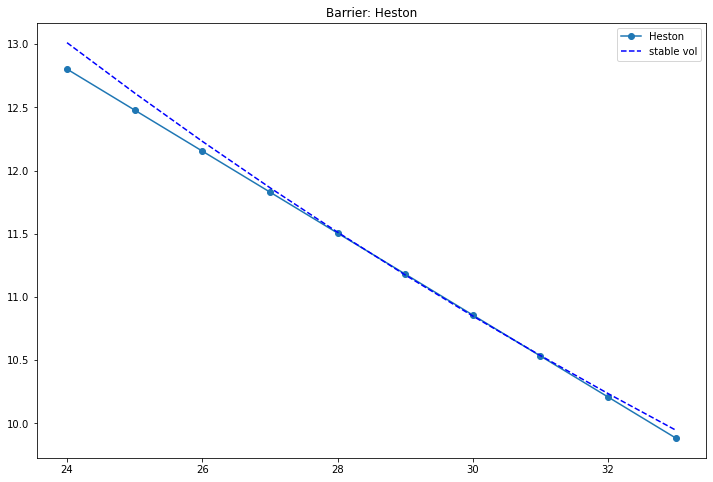

In [16]:
# Up-and-excerise Call
K = np.linspace(0.8*S0, B, 10)
UOCheston = np.zeros(K.shape)
for i in range(0,K.size):
    UOCheston[i] = np.exp(-r*T) * np.mean(np.maximum(S[-1,:] - K[i],0) * I)

fig = plt.figure(figsize=(12,8))
plt.plot(K, UOCheston, 'o-', label='Heston')
plt.plot(K, vectorized_black_scholes_merton('c', S0,K, T, r,np.mean(V), q,return_as='array'), '--b', label='stable vol')
plt.legend()
plt.title('Barrier: Heston')
plt.show()